# Building a Travel Planner with LangGraph: A Tutorial

## Overview

This tutorial guides you through the process of creating a simple Travel Planner using LangGraph, a library for building stateful, multi-step applications with language models. The Travel Planner demonstrates how to structure a conversational AI application that collects user input and generates personalized travel itineraries.

## Motivation

In the realm of AI applications, managing state and flow in multi-step processes can be challenging. LangGraph provides a solution by allowing developers to create graph-based workflows that can handle complex interactions while maintaining a clear and modular structure. This Travel Planner serves as a practical example of how to leverage LangGraph's capabilities to build a useful and interactive application.

## Key Components

1. **StateGraph**: The core of our application, defining the flow of our Travel Planner.
2. **PlannerState**: A custom type representing the state of our planning process.
3. **Node Functions**: Individual steps in our planning process (input_city, input_interests, create_itinerary).
4. **LLM Integration**: Utilizing a language model to generate the final itinerary.

## Method Details

Our Travel Planner follows a straightforward, three-step process:

1. **City Input**: 
   - The application prompts the user to enter the city they want to visit.
   - This information is stored in the state.

2. **Interests Input**:
   - The user is asked to provide their interests for the trip.
   - These interests are stored as a list in the state.

3. **Itinerary Creation**:
   - Using the collected city and interests, the application leverages a language model to generate a personalized day trip itinerary.
   - The generated itinerary is presented to the user.

The flow between these steps is managed by LangGraph, which handles the state transitions and ensures that each step is executed in the correct order.

## Conclusion

This tutorial demonstrates how LangGraph can be used to create a simple yet effective Travel Planner. By structuring our application as a graph of interconnected nodes, we achieve a clear separation of concerns and a easily modifiable workflow. This approach can be extended to more complex applications, showcasing the power and flexibility of graph-based designs in AI-driven conversational interfaces.

The Travel Planner serves as a starting point for developers looking to build more sophisticated stateful applications using language models. It illustrates key concepts such as state management, user input handling, and integration with AI models, all within the framework provided by LangGraph.

### Setup and Imports

First, let's import the necessary modules and set up our environment.

In [1]:
import os
from typing import TypedDict, Annotated, List
from langgraph.graph import StateGraph, END
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain_core.runnables.graph import MermaidDrawMethod
from IPython.display import display, Image
from dotenv import load_dotenv
import os
load_dotenv()
os.environ["OPENAI_API_KEY"] = os.getenv('OPENAI_API_KEY')

### Define Agent State

We'll define the state that our agent will maintain throughout its operation.

In [2]:
class PlannerState(TypedDict):
    messages: Annotated[List[HumanMessage | AIMessage], "The messages in the conversation"]
    city: str
    interests: List[str]
    itinerary: str

### Set Up Language Model and Prompts


In [3]:
llm = ChatOpenAI(model="gpt-4o-mini")


itinerary_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a helpful travel assistant. Create a day trip itinerary for {city} based on the user's interests: {interests}. Provide a brief, bulleted itinerary."),
    ("human", "Create an itinerary for my day trip."),
])

### Define Agent Functions

Now we'll define the main functions that our agent will use: get city, get interests, create itinerary

In [4]:
def input_city(state: PlannerState) -> PlannerState:
    print("Please enter the city you want to visit for your day trip:")
    user_message = input("Your input: ")
    return {
        **state,
        "city": user_message,
        "messages": state['messages'] + [HumanMessage(content=user_message)],
    }

def input_interests(state: PlannerState) -> PlannerState:
    print(f"Please enter your interests for the trip to {state['city']} (comma-separated):")
    user_message = input("Your input: ")
    return {
        **state,
        "interests": [interest.strip() for interest in user_message.split(',')],
        "messages": state['messages'] + [HumanMessage(content=user_message)],
    }

def create_itinerary(state: PlannerState) -> PlannerState:
    print(f"Creating an itinerary for {state['city']} based on interests: {', '.join(state['interests'])}...")
    response = llm.invoke(itinerary_prompt.format_messages(city=state['city'], interests=", ".join(state['interests'])))
    print("\nFinal Itinerary:")
    print(response.content)
    return {
        **state,
        "messages": state['messages'] + [AIMessage(content=response.content)],
        "itinerary": response.content,
    }

### Create and Compile the Graph

Now we'll create our LangGraph workflow and compile it.

In [5]:
workflow = StateGraph(PlannerState)

workflow.add_node("input_city", input_city)
workflow.add_node("input_interests", input_interests)
workflow.add_node("create_itinerary", create_itinerary)

workflow.set_entry_point("input_city")

workflow.add_edge("input_city", "input_interests")
workflow.add_edge("input_interests", "create_itinerary")
workflow.add_edge("create_itinerary", END)

app = workflow.compile()

### Display the graph structure

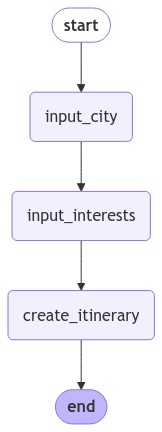

In [6]:
display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

### Define the function that runs the graph

In [7]:
def run_travel_planner(user_request: str):
    print(f"Initial Request: {user_request}\n")
    state = {
        "messages": [HumanMessage(content=user_request)],
        "city": "",
        "interests": [],
        "itinerary": "",
    }
    
    for output in app.stream(state):
        pass  # The nodes themselves now handle all printing

### Use case example

In [8]:
user_request = "I want to plan a day trip."
run_travel_planner(user_request)

Initial Request: I want to plan a day trip.

Please enter the city you want to visit for your day trip:
Please enter your interests for the trip to Madrid (comma-separated):
Creating an itinerary for Madrid based on interests: food, culture, relaxation, art, architecture, music...

Final Itinerary:
### Day Trip Itinerary for Madrid

#### Morning
- **Breakfast at Chocolatería San Ginés**
  - Indulge in traditional churros with hot chocolate.
  
- **Visit the Royal Palace of Madrid**
  - Explore the stunning architecture and lavish interiors.
  - Stroll through the Sabatini Gardens for a relaxing atmosphere.

#### Late Morning
- **Explore the Almudena Cathedral**
  - Admire the beautiful neo-Romanesque and neo-Gothic architecture.

- **Walk through Plaza Mayor**
  - Experience the vibrant atmosphere and grab a coffee at one of the quaint cafés.

#### Lunch
- **Tapas Lunch at Mercado de San Miguel**
  - Sample a variety of Spanish tapas and local delicacies.

#### Afternoon
- **Visit the 

## Run the Agent

Now let's run our agent with a sample request!